# Tutorial for simulating spatial transcriptomics data

We will demonstrate how to simulate spatial transcriptomics data with spatially varying correlation

## Import dependencies

In [2]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
from anndata import AnnData
import importlib
import sys
from statsmodels.stats.multitest import multipletests, fdrcorrection
import json

from simulate_spatial import normalize_deviance_residuals as ndr
from simulate_spatial import simulate_data as sd
from simulate_spatial import plot_spatial as ps

from collections import defaultdict

## Define functions we want to use throughout the notebook

In [3]:
def plot_gene(
        gene, 
        adata, 
        row_key='array_row', 
        col_key='array_col'
    ):
    ind = list(adata.var.index).index(gene)
    expr = X_res[:,ind]
    ps.plot_slide(
        adata.obs, 
        expr, 
        cmap='viridis', 
        #title="UMI count < 2,000",
        dsize=10,
        row_key=row_key,
        col_key=col_key
    )
    plt.title(gene)
    plt.show()
    


## Download a breast cancer dataset from 10x genomics

We're going to use this dataset as a "scaffold" from which to simulate data with known, spatially varying correlation

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Download data
adata_raw = sc.datasets.visium_sge(sample_id="V1_Breast_Cancer_Block_A_Section_1")

# Filter spots
sc.pp.filter_cells(adata_raw, min_counts=5000)
sc.pp.filter_cells(adata_raw, max_counts=35000)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Let's take a  look at the image of the slide

... storing 'feature_types' as categorical
... storing 'genome' as categorical


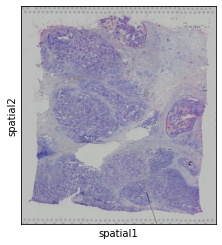

In [5]:
sc.pl.spatial(adata_raw, alpha=0.0)

## Normalize countes using deviance residuals

In [11]:
X_res = ndr.normalize(np.array(adata_raw.X.todense()))
expr_res_df = pd.DataFrame(
    data=X_res,
    index=adata_raw.obs.index,
    columns=adata_raw.var.index
)

# Build the new AnnData object
adata = AnnData(expr_res_df)
adata.obs = adata_raw.obs

expr_res_df

/Users/matthewbernstein/Development/spatial-transcriptomics-simulator/simulate_spatial/normalize_deviance_residuals.py:27: RuntimeWarning: invalid value encountered in true_divide
  np.nan_to_num(2*X*np.log(X/M), copy=True, nan=0.0) \
/Users/matthewbernstein/Development/spatial-transcriptomics-simulator/simulate_spatial/normalize_deviance_residuals.py:27: RuntimeWarning: divide by zero encountered in log
  np.nan_to_num(2*X*np.log(X/M), copy=True, nan=0.0) \
/Users/matthewbernstein/Development/spatial-transcriptomics-simulator/simulate_spatial/normalize_deviance_residuals.py:27: RuntimeWarning: invalid value encountered in log
  np.nan_to_num(2*X*np.log(X/M), copy=True, nan=0.0) \
/Users/matthewbernstein/Development/spatial-transcriptomics-simulator/simulate_spatial/normalize_deviance_residuals.py:27: RuntimeWarning: invalid value encountered in multiply
  np.nan_to_num(2*X*np.log(X/M), copy=True, nan=0.0) \
Variable names are not unique. To make them unique, call `.var_names_make_uniq

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,-0.00000,0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.0
AAACAGGGTCTATATT-1,0.0,0.0,0.0,-0.00000,0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.0
AAACATTTCCCGGATT-1,0.0,0.0,0.0,5.05372,0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.0
AAACCCGAACGAAATC-1,0.0,0.0,0.0,-0.00000,0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,6.713325,-0.0
AAACCTAAGCAGCCGG-1,0.0,0.0,0.0,-0.00000,0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.0,0.0,0.0,-0.00000,0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,4.647659,-0.0
TTGTTTCACATCCAGG-1,0.0,0.0,0.0,-0.00000,0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.0
TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,-0.00000,0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.0
TTGTTTCCATACAACT-1,0.0,0.0,0.0,-0.00000,0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.0


## Plot the expression of a few genes across the slide

This is just a sanity check that we've loaded the data correctly

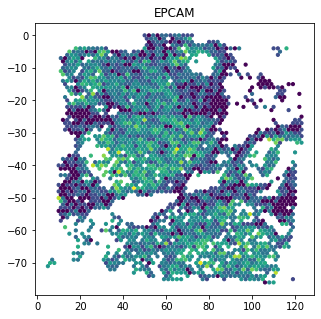

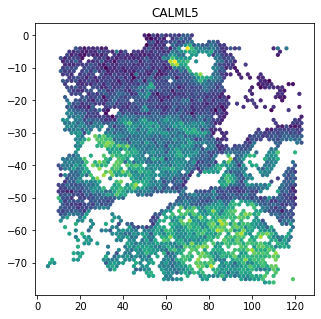

In [12]:
importlib.reload(ps)
plot_gene('EPCAM', adata)
plot_gene('CALML5', adata)

## Simulate a dataset based on this real dataset

In [13]:
importlib.reload(sd)

corr_mean = 0      # <- Set the mean correlation across the slide to zero
gene_1 = 'EPCAM'   # <- Set the mean of the first gene to be the mean of EPCAM
gene_2 = 'CALML5'  # <- Set the mean of the second gene to be CALML5
sigma = 10         # <- Set the Gaussian kernel width. The larger this value, the larger the spatial structure
cov_strength = 0.2

corrs, covs, adata_sim = sd.simulate_pairwise_from_dataset(
    adata,
    corr_mean, 
    gene_1,
    gene_2,
    row_key='array_row',
    col_key='array_col',
    sigma=sigma,
    cov_strength=cov_strength,
    poisson=False,
    size_factors=None
)

## Let's plot the simulated expression values across the slide for each gene

Notice how there are no clear expression patterns for either gene

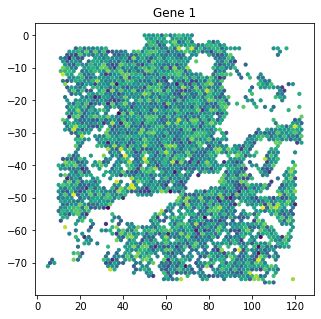

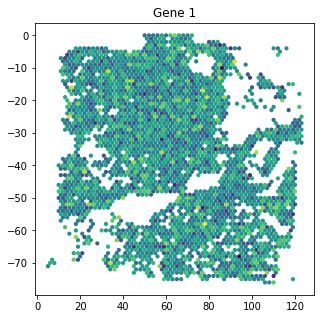

In [14]:
ps.plot_slide(
    adata.obs, 
    adata_sim.X.T[0], 
    cmap='viridis', 
    dsize=10,
    title='Gene 1',
    row_key='array_row',
    col_key='array_col'
)

ps.plot_slide(
    adata.obs, 
    adata_sim.X.T[1], 
    cmap='viridis', 
    dsize=10,
    title='Gene 1',
    row_key='array_row',
    col_key='array_col'
)

## Let's plot their true underlying correlations at each spot

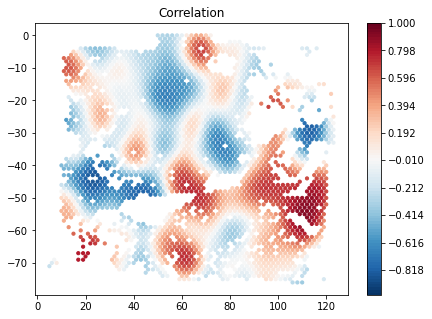

In [16]:
ps.plot_slide(
    adata.obs, 
    corrs, 
    cmap='RdBu_r', 
    dsize=10,
    colorbar=True,
    vmin=-1,
    vmax=1,
    title='Correlation',
    row_key='array_row',
    col_key='array_col'
)

## Let's play around with the parameters of this simulation

### First, let's vary `sigma`. We'll see that as `sigma` increases, the correlation patterns become more coarse

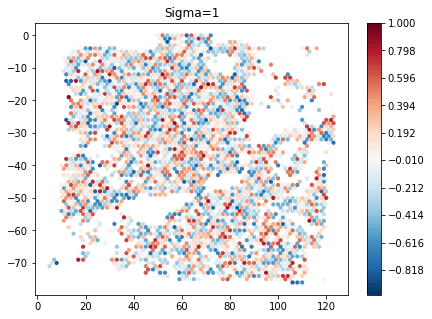

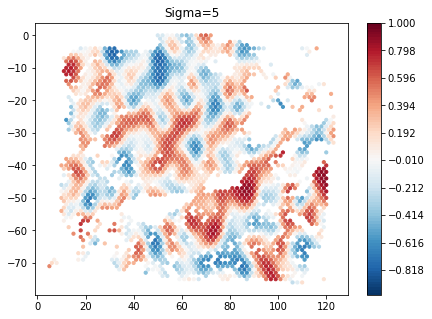

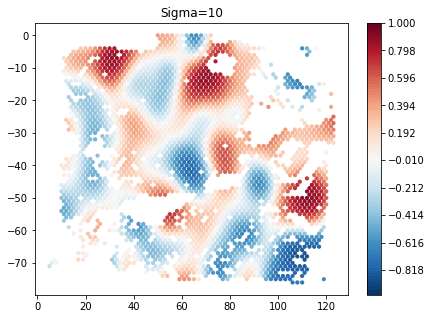

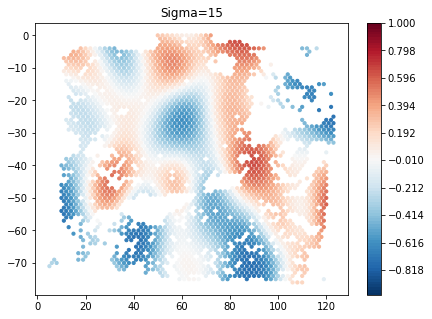

In [17]:
for sigma in [1, 5, 10, 15]:
    corrs, covs, adata_sim = sd.simulate_pairwise_from_dataset(
        adata,
        corr_mean, 
        gene_1,
        gene_2,
        row_key='array_row',
        col_key='array_col',
        sigma=sigma,
        cov_strength=0.2,
        poisson=False,
        size_factors=None
    )
    ps.plot_slide(
        adata.obs, 
        corrs, 
        cmap='RdBu_r', 
        dsize=10,
        colorbar=True,
        vmin=-1,
        vmax=1,
        title=f'Sigma={sigma}',
        row_key='array_row',
        col_key='array_col'
    )
    plt.show()

### Now let's vary `cov_strength`. We'll see that as `cov_strength` increases, the correlation magnitudes become larger

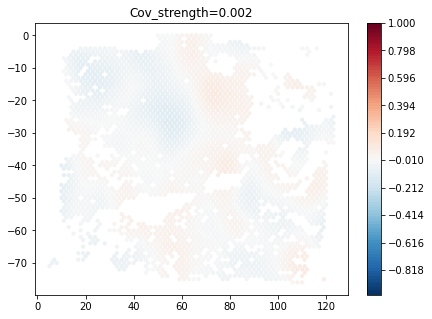

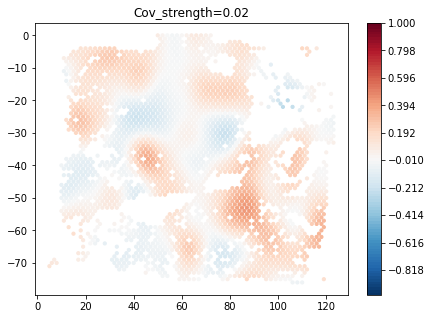

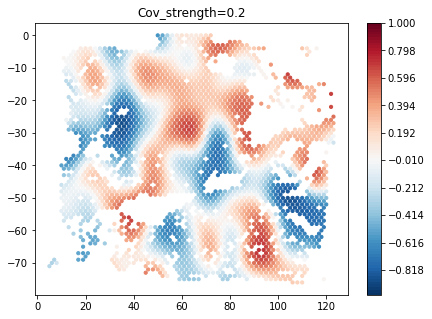

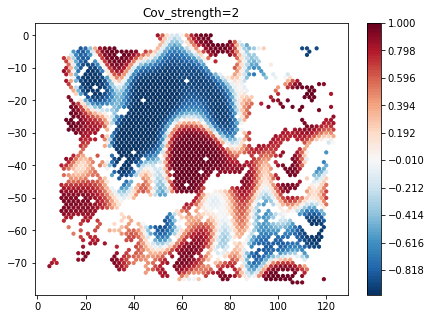

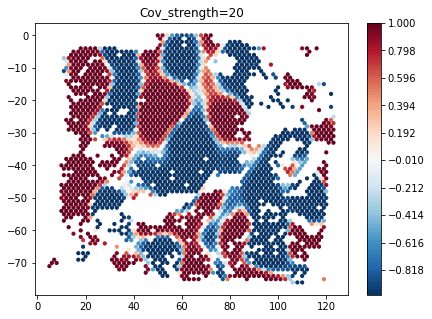

In [18]:
for cov_strength in [0.002, 0.02, 0.2, 2, 20]:
    corrs, covs, adata_sim = sd.simulate_pairwise_from_dataset(
        adata,
        corr_mean, 
        gene_1,
        gene_2,
        row_key='array_row',
        col_key='array_col',
        sigma=10,
        cov_strength=cov_strength,
        poisson=False,
        size_factors=None
    )
    ps.plot_slide(
        adata.obs, 
        corrs, 
        cmap='RdBu_r', 
        dsize=10,
        colorbar=True,
        vmin=-1,
        vmax=1,
        title=f'Cov_strength={cov_strength}',
        row_key='array_row',
        col_key='array_col'
    )
    plt.show()